# Results and Visualization

This notebook is a part of the replication package for my ICSE'22 paper.

In this notebook I conduct a t-test between the mean scores of my approach and LDA for a given number of topics. I also evaluate the effect size of the difference and visualize the results.

This notebook consists of the following sections:
- **Visualization**
- **Statistical Analysis**
- **Final Remarks and Future Work**

The scores produced for each configuration of my approach and LDA can be found in the `scores` folder.

In [1]:
# this script plots the results and computes the t-test
from os import listdir
import pickle

data = {}

for file in listdir('scores/investing'):
    with open('scores/investing/' + file, 'rb') as f:
        try:
            data['investing_' + file[:-4]] = pickle.load(f)
        except:
            print(file)
for file in listdir('scores/food'):
    with open('scores/food/' + file, 'rb') as f:
        try:
            data['food_' + file[:-4]] = pickle.load(f)
        except:
            print(file)

In [2]:
data.keys()

dict_keys(['investing_key_corpus_0', 'investing_key_corpus_10', 'investing_key_corpus_15', 'investing_key_corpus_25', 'investing_key_corpus_5', 'investing_key_wiki_0', 'investing_key_wiki_10', 'investing_key_wiki_15', 'investing_key_wiki_25', 'investing_key_wiki_5', 'investing_lda_corpus', 'investing_lda_wiki', 'food_key_corpus_0', 'food_key_corpus_15', 'food_key_corpus_25', 'food_key_corpus_5', 'food_key_wiki_0', 'food_key_wiki_15', 'food_key_wiki_25', 'food_key_wiki_5', 'food_lda_corpus', 'food_lda_wiki'])

Each key in the `data` dictionary corresponds to a list with 10 elements, where each element is a set of scores for a given number of topics: from 10 to 100. For example, the `investing_key_corpus_10` contains scores for 10-100 topics with 10th bottom percentile removed keywords produced by my approach for the investing dataset and evaluated using the intrinsic (corpus) NPMI.

In [4]:
# 10 topics (summaries) were used to produce these scores
data['investing_key_corpus_10'][0]

[0.12871049966511403,
 0.08749096496125108,
 0.13808208675879408,
 0.16141119178319024,
 0.1397320768213412,
 0.13225489781676839,
 0.1890484175063979,
 0.08788066778395319,
 0.1565197000128567,
 0.0959405886473515]

## Vizualization

The code below visualizes the results for each keyATM configuration and LDA, measured in the average intrinsic coherence (NPMI) over each given number of topics.

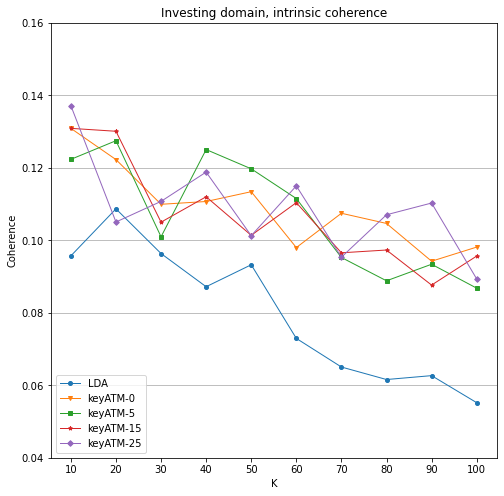

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))

ymin = 0.04
ymax = 0.16
markersize = 4

for i in np.arange(ymin, ymax, 0.02):
    plt.axhline(i, color='gray', linewidth=0.5)


plt.plot([np.mean(l) for l in data['investing_lda_corpus']], "-o", linewidth=1, label="LDA", markersize=markersize)
plt.plot([np.mean(l) for l in data['investing_key_corpus_0']], "-v", linewidth=1, label="keyATM-0", markersize=markersize)
plt.plot([np.mean(l) for l in data['investing_key_corpus_5']], "-s", linewidth=1, label="keyATM-5", markersize=markersize)
plt.plot([np.mean(l) for l in data['investing_key_corpus_15']], "-*", linewidth=1, label="keyATM-15", markersize=markersize)
plt.plot([np.mean(l) for l in data['investing_key_corpus_25']], "-D", linewidth=1, label="keyATM-25", markersize=markersize)
plt.ylim(ymin, ymax)
plt.xticks(list(range(10)), list(range(10, 110, 10)))
plt.xlabel("K")
plt.ylabel("Coherence")
plt.title("Investing domain, intrinsic coherence")
plt.legend(loc='lower left')
plt.show()

As shown on the plot, my approach consistently outperforms LDA for any given number of topics. We can also observe a decreasing trend in topic quality as the number of topics goes up. However, the trend is far less pronounced for keyATM compared to LDA.

The figure also suggests that the best performance is achieved for 10 topics with 25th bottom percentile of keywords removed. These results are expected since the investing domain dataset contains only 20k reviews, which is a relatively small number for a topic model. 

The rest of the results for other configurations and datasets can be found in my paper.

## Statistical Analysis

To verify that the visible difference in the means translates to actual difference, I conducted an independent t-test between the model configurations and LDA and measured to effect size using Cohen's d and Hedges' g.

First, we verify the assumptions for the tests, namely, the normality. As our sample sizes are relatively small (10-100), the normality assumption is necessary here. For larger sample sizes it is not necessary due to the CLT.

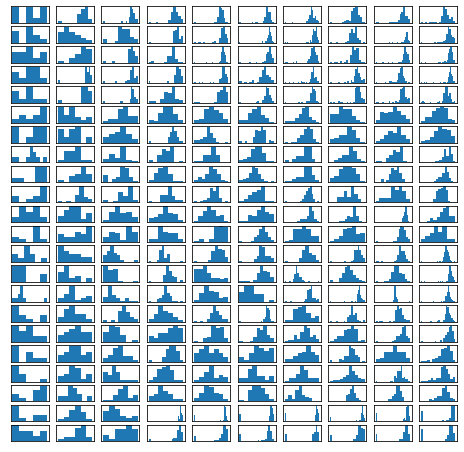

In [43]:
import matplotlib.pyplot as plt

Tot = len(data.keys()) * 10
Cols = 10

Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1, figsize=(8,8))
i = 1
for k in data.keys():
    for j in range(len(data[k])):
        ax = fig.add_subplot(Rows,Cols,i)
        ax.hist(data[k][j], bins='auto')
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1
plt.show()

We can observe that the majority of topic scores distributions are approximately normal, with some exceptions (bottom right). However, these are not critical since the sample size is also larger for those on the right, so the means will be normally distributed anyway.

Another assumption is the homogeneity of variances, which I verify for the "problematic" cases (bottom right on the diagram). Here is an example where the variances are unequal.

In [47]:
from scipy.stats import tstd
for key,lda in zip(data['food_lda_corpus'], data['food_key_corpus_15']):
    print(f"{tstd(key):.2f}, {tstd(lda):.2f}")

0.02, 0.02
0.04, 0.02
0.03, 0.03
0.21, 0.03
0.31, 0.02
0.33, 0.04
0.33, 0.04
0.27, 0.03
0.32, 0.03
0.38, 0.09


Fortunately, scipy's t-test provides an argument for unequal variances, which essentially tranforms it to Welch's test. In the next cell I compute the t, p, and g statistic for each pair of scores.

In [51]:
# investing

from numpy import mean, var, sqrt

def cohend(d1, d2, bias_corr=False):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    if bias_corr:
        N = n1 + n2
        return ((u1 - u2) / s) * (N - 3) / (N - 2.25) * sqrt((N - 2) / N)
    return (u1 - u2) / s

from scipy.stats import ttest_ind

pairs = [('investing_key_wiki_0', 'investing_lda_wiki'), ('investing_key_corpus_0', 'investing_lda_corpus'),
        ('investing_key_wiki_5', 'investing_lda_wiki'), ('investing_key_corpus_5', 'investing_lda_corpus'),
        ('investing_key_wiki_15', 'investing_lda_wiki'), ('investing_key_corpus_15', 'investing_lda_corpus'),
        ('investing_key_wiki_25', 'investing_lda_wiki'), ('investing_key_corpus_25', 'investing_lda_corpus')]

for i in range(len(data['investing_lda_wiki'])):
    t1, p1 = ttest_ind(data['investing_key_wiki_0'][i], data['investing_lda_wiki'][i], equal_var=False)
    d1 = cohend(data['investing_key_wiki_0'][i], data['investing_lda_wiki'][i], bias_corr=True)
    
    t2, p2 = ttest_ind(data['investing_key_corpus_0'][i], data['investing_lda_corpus'][i], equal_var=False)
    d2 = cohend(data['investing_key_corpus_0'][i], data['investing_lda_corpus'][i], bias_corr=True)
    
    t3, p3 = ttest_ind(data['investing_key_wiki_5'][i], data['investing_lda_wiki'][i], equal_var=False)    
    d3 = cohend(data['investing_key_wiki_5'][i], data['investing_lda_wiki'][i], bias_corr=True)
    
    t4, p4 = ttest_ind(data['investing_key_corpus_5'][i], data['investing_lda_corpus'][i], equal_var=False)
    d4 = cohend(data['investing_key_corpus_5'][i], data['investing_lda_corpus'][i], bias_corr=True)
    
    t5, p5 = ttest_ind(data['investing_key_wiki_15'][i], data['investing_lda_wiki'][i], equal_var=False)
    d5 = cohend(data['investing_key_wiki_15'][i], data['investing_lda_wiki'][i], bias_corr=True)
    
    t6, p6 = ttest_ind(data['investing_key_corpus_15'][i], data['investing_lda_corpus'][i], equal_var=False)
    d6 = cohend(data['investing_key_corpus_15'][i], data['investing_lda_corpus'][i])
    
    t7, p7 = ttest_ind(data['investing_key_wiki_25'][i], data['investing_lda_wiki'][i], equal_var=False)
    d7 = cohend(data['investing_key_wiki_25'][i], data['investing_lda_wiki'][i])
    
    t8, p8 = ttest_ind(data['investing_key_corpus_25'][i], data['investing_lda_corpus'][i], equal_var=False)
    d8 = cohend(data['investing_key_corpus_25'][i], data['investing_lda_corpus'][i])
    
    tlist = [t1, t2, t3, t4, t5, t6, t7, t8]
    plist = [p1, p2, p3, p4, p5, p6, p7, p8]
    dlist = [d1, d2, d3, d4, d5, d6, d7, d8]
    
    for t,p,d, pair in zip(tlist, plist, dlist, pairs):
        if p < 0.05:
            print(f"{(i+1)*10} topics. {pair[0]} and {pair[1]}: t={t:.2f}, p={p:.2f}, d={d:.2f}")

10 topics. investing_key_corpus_0 and investing_lda_corpus: t=2.60, p=0.02, d=1.06
10 topics. investing_key_corpus_15 and investing_lda_corpus: t=2.86, p=0.01, d=1.28
10 topics. investing_key_corpus_25 and investing_lda_corpus: t=3.22, p=0.01, d=1.44
40 topics. investing_key_corpus_5 and investing_lda_corpus: t=3.54, p=0.00, d=0.77
40 topics. investing_key_wiki_25 and investing_lda_wiki: t=2.23, p=0.03, d=0.50
50 topics. investing_key_wiki_0 and investing_lda_wiki: t=2.42, p=0.02, d=0.48
50 topics. investing_key_wiki_5 and investing_lda_wiki: t=2.13, p=0.04, d=0.42
50 topics. investing_key_corpus_5 and investing_lda_corpus: t=2.13, p=0.04, d=0.42
50 topics. investing_key_wiki_15 and investing_lda_wiki: t=3.02, p=0.00, d=0.59
50 topics. investing_key_wiki_25 and investing_lda_wiki: t=2.64, p=0.01, d=0.53
60 topics. investing_key_corpus_5 and investing_lda_corpus: t=3.21, p=0.00, d=0.58
60 topics. investing_key_corpus_15 and investing_lda_corpus: t=2.93, p=0.00, d=0.54
60 topics. investi

I printed out the significant results, along with the effect size. 

***Observations:*** for investing domain we can see that at 10, and ~50-100 topics my approach produces higher quality topics, than LDA. The results are more or less consistent for each bottom n-th percentile removed. In addition, the effect size values suggest that 10 topics is actully the sweet spot for this paticular dataset.

## Final Remarks and Future Work

This study has been conducted in very unusual circumstances. Initially, we were aimed to focus on Investing apps alone to study what users of those apps care the most about. However, over time we had developed a full approach of extracting user concerns from any domain of apps, given enough user reviews. The study took about a half a year to fully implement and compute the results. When we were ready to finalize the paper for the ICSE submission in late August 2021, Louisiana got hit hard by hurricane Ida and we lost power for 3 weeks. The last days before the submission we had to meet in a humid, hot local coffee shop without power to proofread and finish the paper using the natural light from the windows. It was difficult, and as a result, there were some things that I was not able to do for this paper simply due to the fact that I couldn't turn on my computer.

- We noticed that the topic quality is mostly dependent on the quality of the keywords. Therefore, more attention should be put toward improving and refining the keywords. One of the things that I did was introducing basic keyword filtering based on the NPMI score. However, it was not perfect. Sometimes, good keywords were thrown out which, I believe, had affected the quality of the topics in the end. My basic filter relied on intrinsic score, but I later found out that extrinsic score would produce much better keywords. 
- As it stands now, computing topic models over even a small dataset of reviews using keyATM is extremely costly and unoptimized. When a new review comes in - the whole topic model needs to be recomputed. A better approach would use something like Online LDA and adapt it to keyATM to work with keywords. In addition, keyATM itself should be optimized for parallel computation. Faster computation would allow for more tests of other domains of apps.
- Human evaluation was initially tried, but later abandoned due to the fact that humans were having a hard time understanding the task. In the future, a more careful approach to evaluation would be necessary. Even though NPMI is very close to human evaluation, it is not clear, for example, how developers would actually perceive and interpret the resulting topics and what insights would they be able to extract from them to improve their products.